In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
#from nifti import NiftiImage
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

# Open data

In [2]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/100632series/100632/100632seriespreprocessed238Smith0_4_60TS.mat


In [3]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(30511, 238)

In [4]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/100632series/100632/100632seriespreprocessed238Smith0_4_60IC.nii


In [5]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(78, 55, 10, 238)

In [6]:
S=data.shape
S

(78, 55, 10, 238)

Z-score

In [7]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [8]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [9]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

# Open Masks

In [10]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie/db554c18-e3eb-41e2-afad-7de1c92bf4a5/ArclightCombo/100632series/100632seriesRegistration/JFRCTransformedLargefullpsftrimmed.nii


In [11]:
filenameM='/home/sophie/LargeRegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.replace('\n','').split(' ') for Line in content]
RegionName=[Names[i][1] for i in range(12)]
Num=[int(Names[i][0]) for i in range(12)]

In [12]:
RegionName

['OL',
 'VLNP',
 'VMNP',
 'AL',
 'MB',
 'LH',
 'SNP',
 'CX',
 'LX',
 'INP',
 'PENP',
 'GNG']

# Average in masks to sort components by brain region

In [13]:
Dmaps.shape

(78, 55, 10, 238)

In [14]:
M=np.zeros((S[3],13))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(13)

In [15]:
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(12):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [16]:
CompMainName=S[3]*['']
CompNameAdd=np.zeros((S[3],12))
for i in range(S[3]):
    Max=np.max(M[i,:])
    I=np.argmax(M[i,:])+1
    for j in range(12):
        J=[l for l in range(12) if Num[l]==(j+1)]
        if M[i,j]>0.2*Max:
            CompNameAdd[i,J]=1
    J=[l for l in range(12) if Num[l]==I]
    if J!= []:
        CompMainName[i]=Names[np.array(J)][0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [17]:
J

[0]

OL


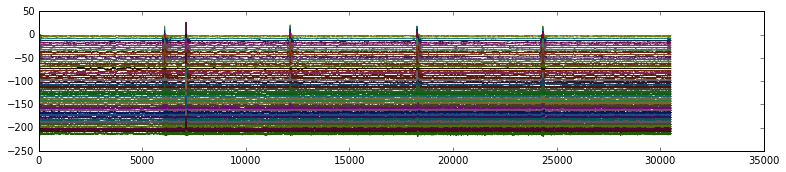

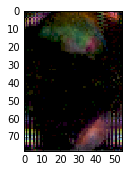

VLNP


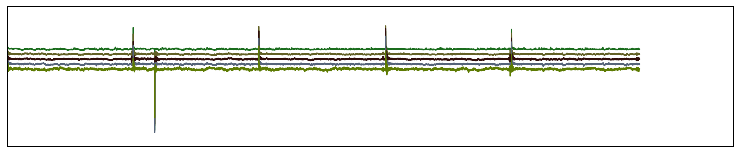

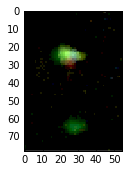

VMNP


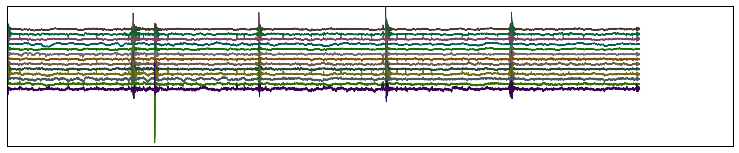

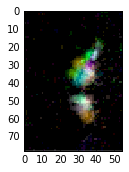

AL


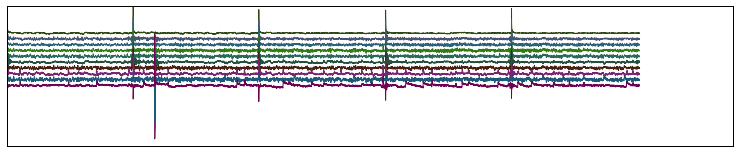

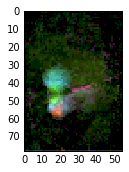

MB


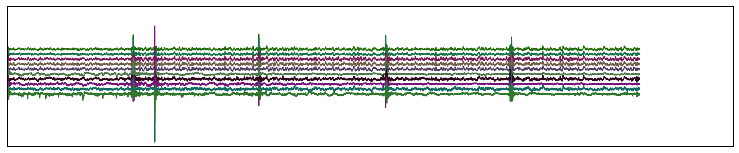

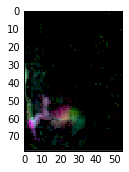

LH


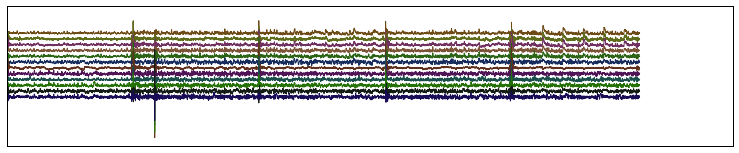

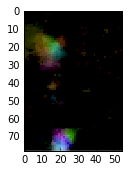

SNP


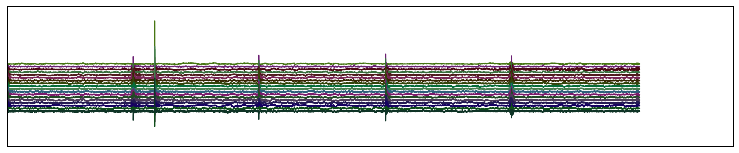

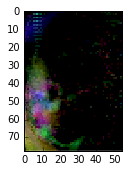

CX


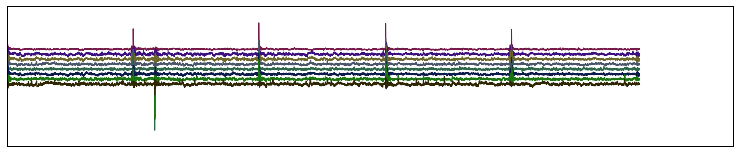

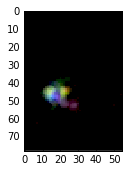

INP


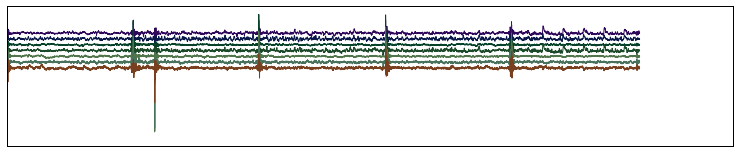

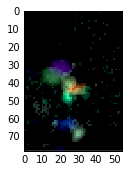

PENP


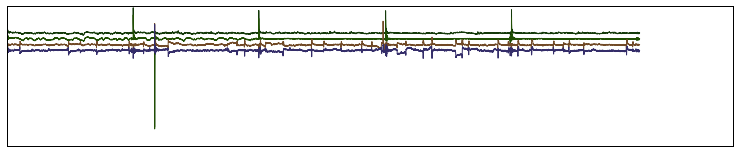

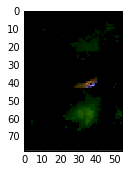

GNG


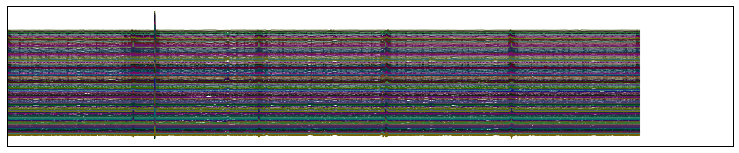

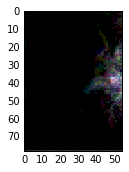

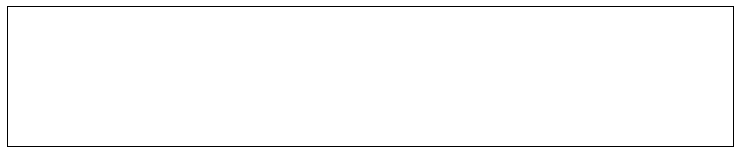

In [18]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        


##### Looked at the components maps and time series and remove all the components which are localized on the edge of the brain and with activity unlike GCaMP6 transients.


In [24]:
BadICs=[105,103,191,195,198,10,141,37,74,16,39,43,64,67,68,214,223,199,224,174,0,89,38,117,206,213,71,94,110,77,124,129,145,181,185,197,201,205,218,219,222,225,226,227,228,229,230,231,232,233,234,235,236,237,11,17,27,29,32,34,35,47,49,50,52,55,60,62,65,69,73,75,83,84,86,88,90,95,101,102,106,107,108,113,115,116,118,119,121,122,123,128,130,131,134,135,136,140,142,143,144,147,149,154,155,156,157,158,159,160,162,166,170,171,172,175,176,177,180,182,183,184,186,187,189,190,192,196,202,204,207,209,211]

In [25]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

6
8
23
25
33
40
54
82
114
132
133
153
194
221
OL


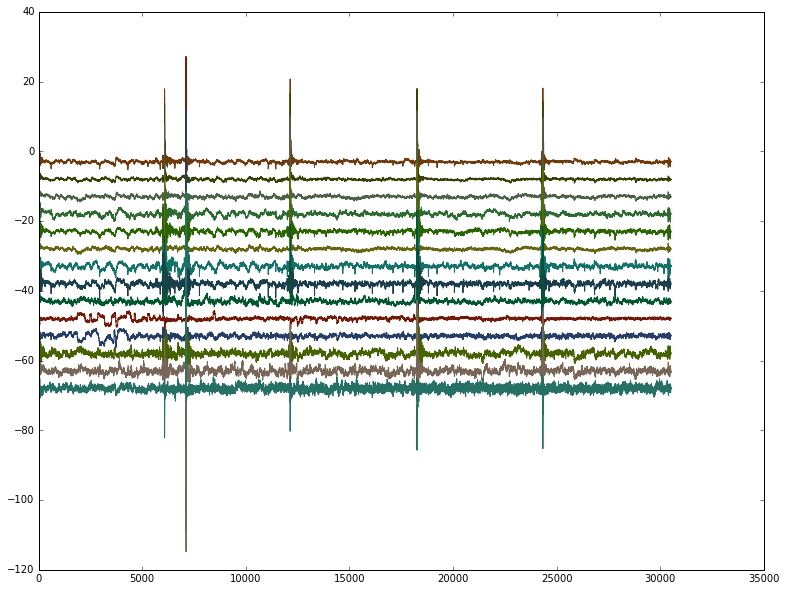

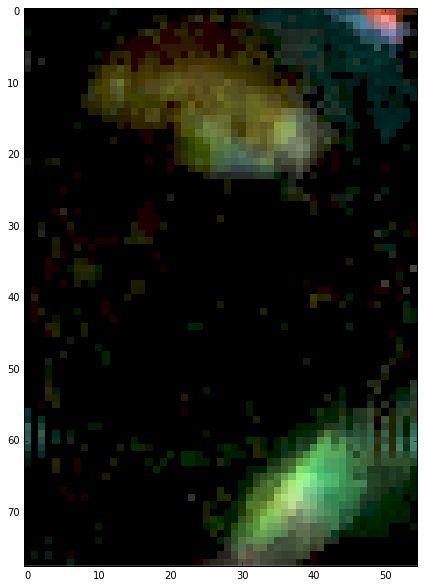

20
46
92
96
200
VLNP


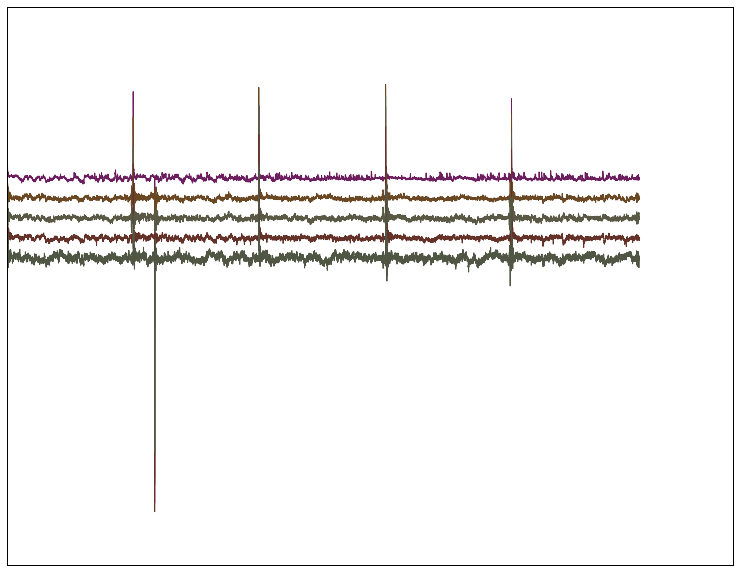

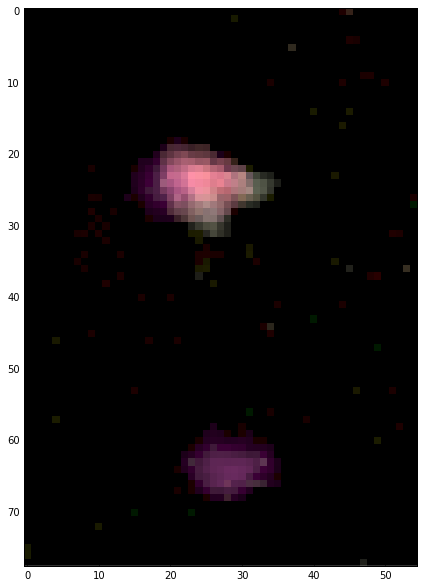

41
57
58
66
70
76
79
91
99
100
146
151
203
VMNP


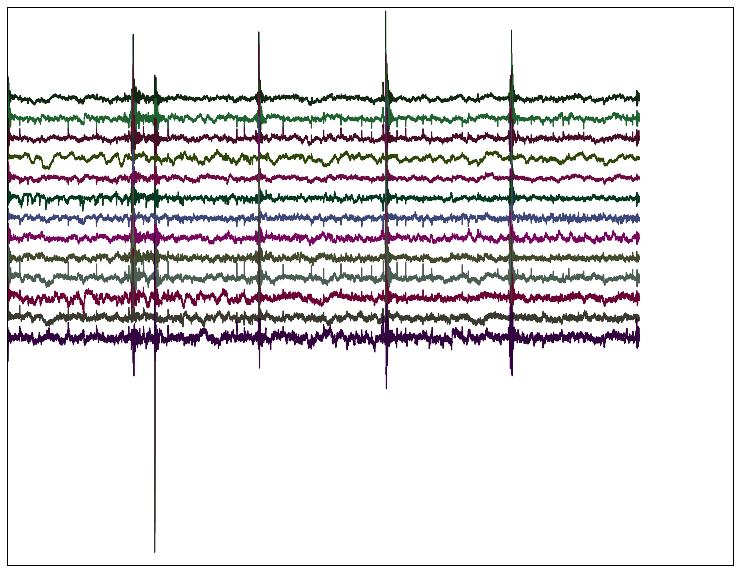

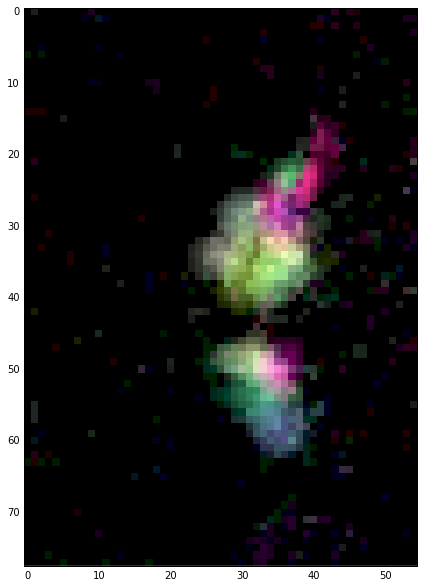

12
14
44
53
81
98
188
AL


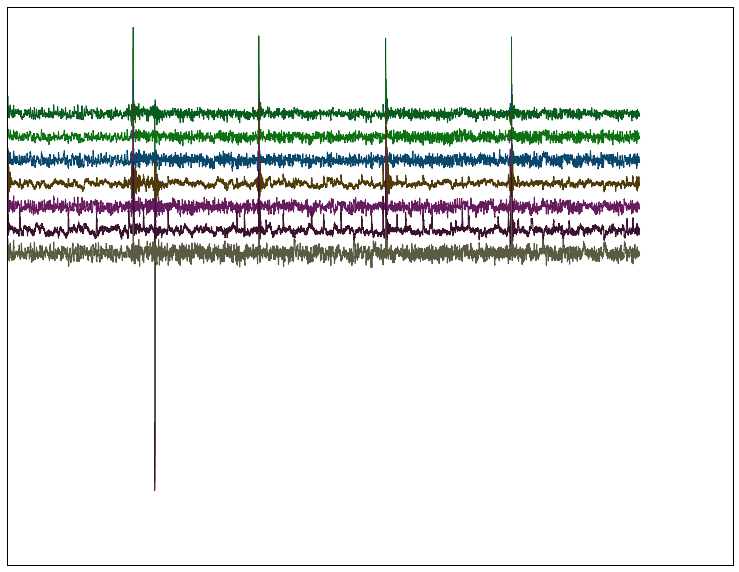

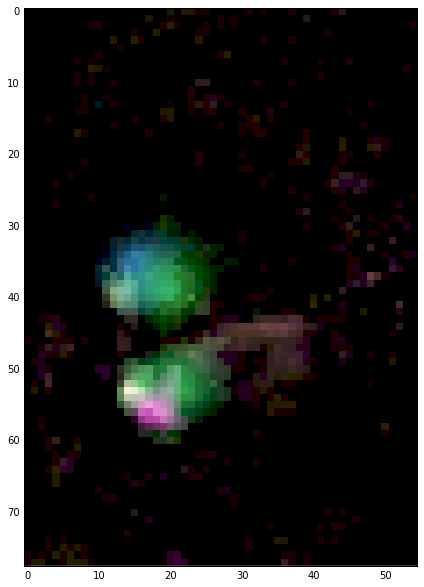

1
5
7
9
31
42
MB


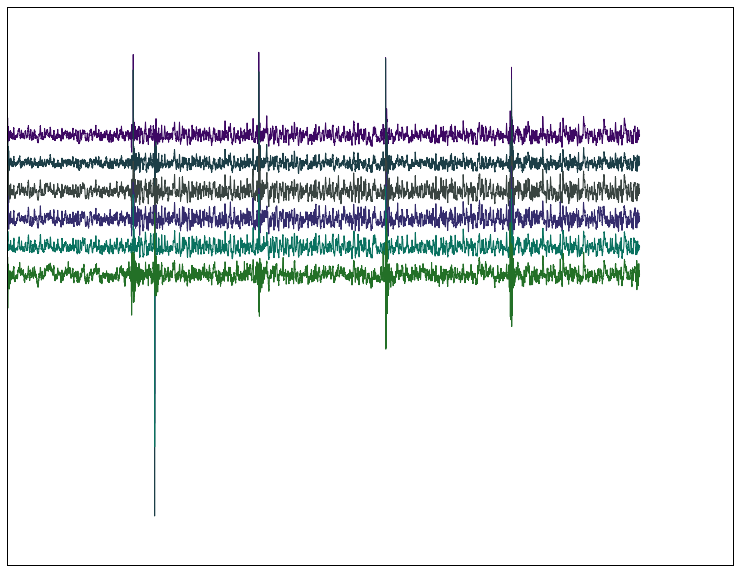

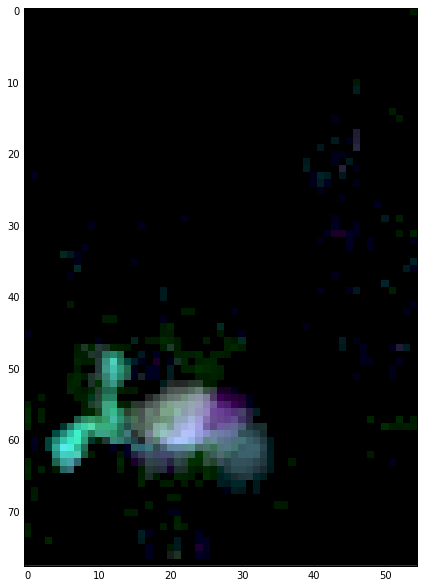

13
21
22
24
30
45
56
59
63
85
104
111
LH


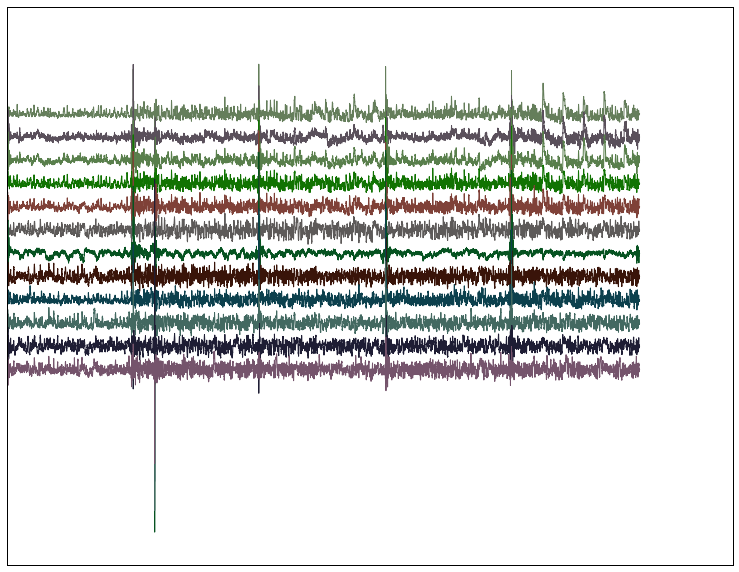

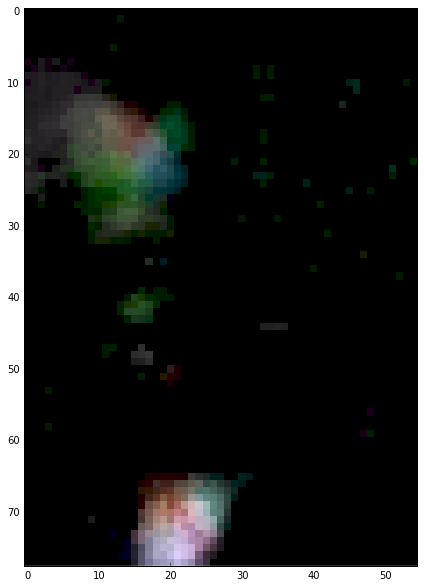

19
26
28
61
72
87
97
112
127
137
138
148
168
173
179
212
SNP


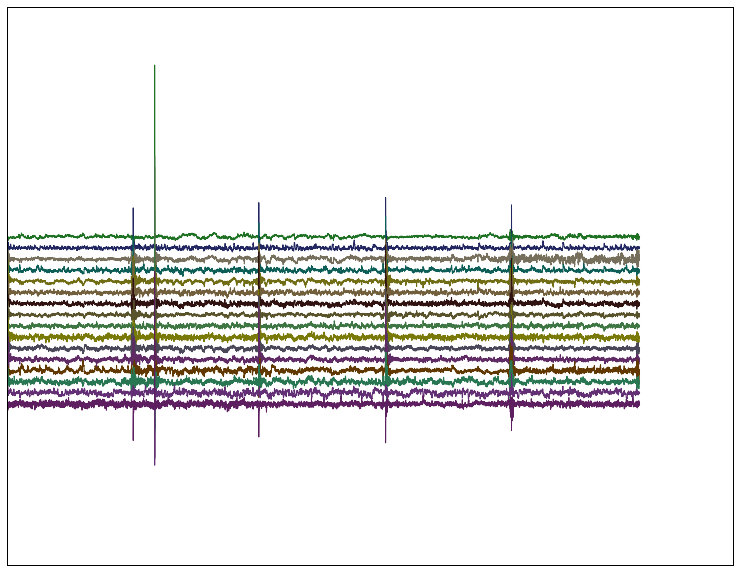

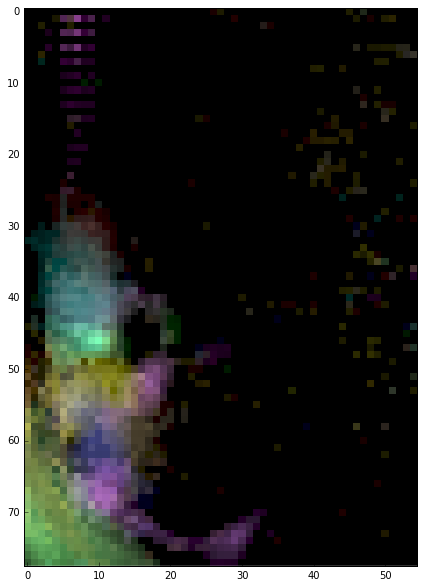

15
109
120
126
163
164
169
210
CX


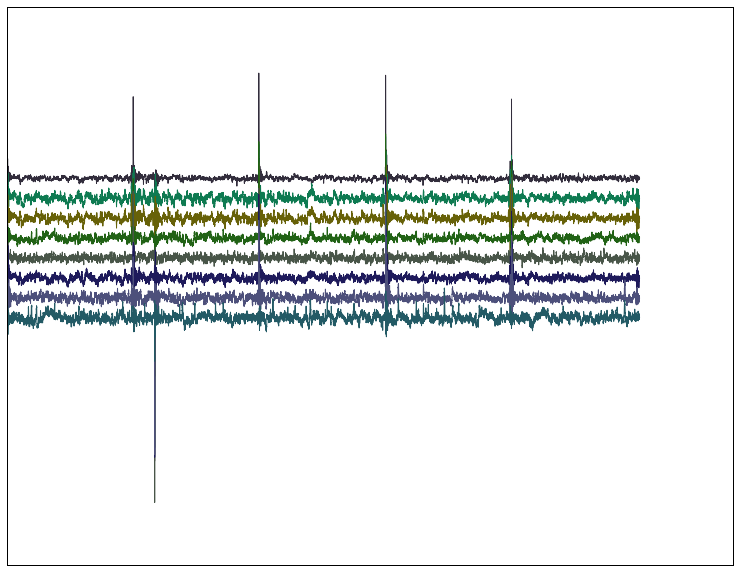

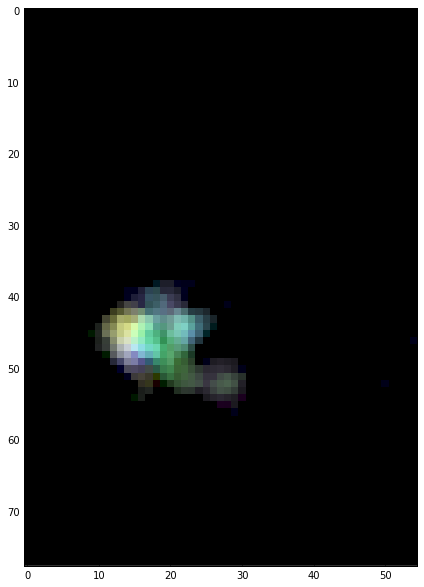

2
3
18
36
51
139
165
INP


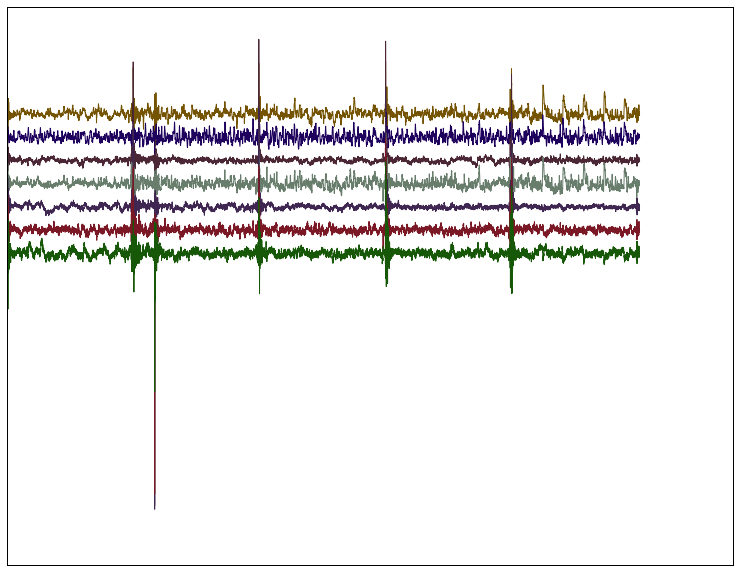

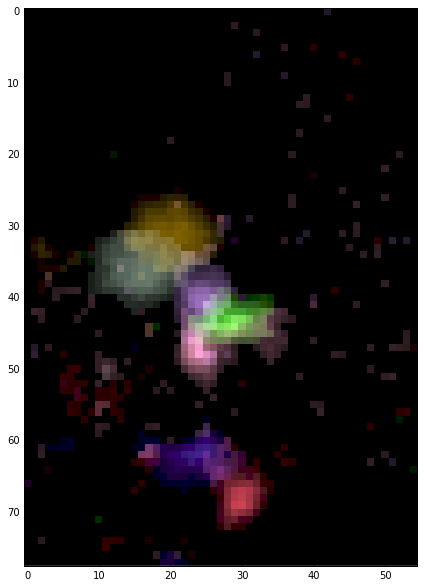

4
PENP


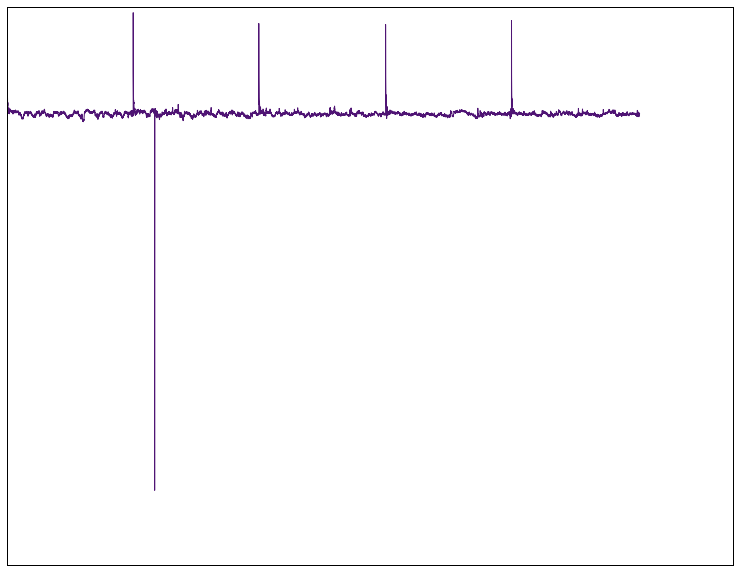

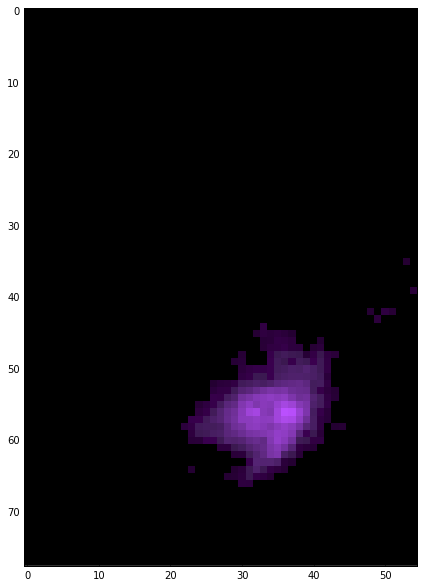

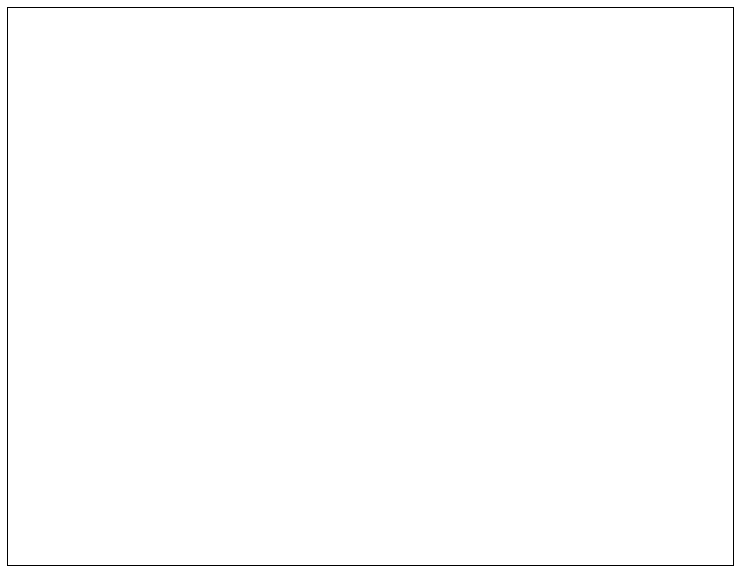

In [28]:
pylab.rcParams['figure.figsize'] = (13, 10)

h=5
tot=0
NumberInLargeRegion=np.zeros(13)

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200 and GoodICAnat[i]==1:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*(C[k]+0.2)/np.max(C+0.2)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            print(i)
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
                
    NumberInLargeRegion[l]=n
        

In [27]:
# Output number of component per region
np.savetxt('/'.join(filename.split('/')[:-1])+'/NumberInLargeRegionsV2.txt',NumberInLargeRegion)